

# Raster analysis in Julia in 45 minutes

This tutorial is based on the xarray in 45 minutes 
https://tutorial.xarray.dev/overview/xarray-in-45-min.html

In this lesson, we discuss cover the basics of Raster analysis data structures. By the
end of the lesson, we will be able to:

- Understand the basic data structures in Julia
- Inspect `DimArray` and `DimStack` objects.
- Read and write netCDF files using Rasters.jl.
- Understand that there are many packages that build on top of xarray


We'll start by reviewing the various components of the Xarray data model, represented here visually:

<img src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png" align="center" width="50%">

As example data we use the data in the xarray-data repository

Here we'll use `air temperature` from the [National Center for Environmental Prediction](https://www.weather.gov/ncep/). Xarray objects have convenient HTML representations to give an overview of what we're working with:

Before we can start we need to activate the current environment

In [1]:
]activate .

  Activating project at `~/Documents/JuliaGeoTutorials`


In [2]:
using Rasters
using NCDatasets

path = "data/air_temperature.nc"
# First we download the data locally if needed.
if !isfile(path)
    download("https://github.com/pydata/xarray-data/blob/master/air_temperature.nc", "air_temperature.nc")
end

# Now we can open the data as a RasterStack
ds = RasterStack(path)

╭────────────────────────╮
│ 53×25×2920 RasterStack │
├────────────────────────┴─────────────────────────────────────────────── dims ┐
  ↓ X  Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  ↗ Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :air eltype: Float64 dims: X, Y, Ti size: 53×25×2920
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 5 entries:
  "references"  => "http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly…
  "platform"    => "Model"
  "title"       => "4x daily NMC reanalysis (1948)"
  "description" => "Data is from NMC initialized reanalysis\n(4x/day).  These a…
  "Conventions" => "COARDS"
├────────────────────────────────────────

## What's in a DimStack? 

*Many DimArrays!* 

DimStacks are dictionary-like containers of "DimArray"s. They are a mapping of
variable name to DimArray.
The RasterStack is a special case of a DimStack with some geospatial information.
The DimArray s in the DimStack can share dimensions butdon't have all the same dimensionality.
If layers share a dimension name, this dimension is only stored once for the whole DimStack.

In [3]:
# pull out "air" dataarray with dictionary syntax
ds["air"]

╭──────────────────────────────────╮
│ 53×25×2920 Raster{Float64,3} air │
├──────────────────────────────────┴───────────────────────────────────── dims ┐
  ↓ X  Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  ↗ Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 12 entries:
  "long_name"    => "4xDaily Air temperature at sigma level 995"
  "scale_factor" => 0.01
  "GRIB_name"    => "TMP"
  "precision"    => 2
  "var_desc"     => "Air temperature"
  "actual_range" => Float32[185.16, 322.1]
  "statistic"    => "Individual Obs"
  "GRIB_id"      => 11
  "dataset"      => "NMC Reanalysis"
  "units"        => "degK"
  "parent_stat"  => "Other"
  "level_desc"   => "Surface"
├───────────────────────

You can save some typing by using the "attribute" or "dot" notation and using tab completion. 


In [4]:
# pull out dataarray using dot notation
ds.air

╭──────────────────────────────────╮
│ 53×25×2920 Raster{Float64,3} air │
├──────────────────────────────────┴───────────────────────────────────── dims ┐
  ↓ X  Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  ↗ Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 12 entries:
  "long_name"    => "4xDaily Air temperature at sigma level 995"
  "scale_factor" => 0.01
  "GRIB_name"    => "TMP"
  "precision"    => 2
  "var_desc"     => "Air temperature"
  "actual_range" => Float32[185.16, 322.1]
  "statistic"    => "Individual Obs"
  "GRIB_id"      => 11
  "dataset"      => "NMC Reanalysis"
  "units"        => "degK"
  "parent_stat"  => "Other"
  "level_desc"   => "Surface"
├───────────────────────

## What's in a DimArray? 

*data + (a lot of) metadata*



### Name (optional)

In [5]:
da = ds.air

Rasters.name(da)

:air

### Named dimensions 

`dims(da)` correspond to the axes of your data. 

In this case we have 2 spatial dimensions (`X` and `Y`) and one temporal dimension (`Ti`).

In [6]:
dims(da)

↓ X  Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
→ Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
↗ Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points

You can also extract a single dimension.

In [7]:
# extracting coordinate variables
dims(da, X)

X Mapped{Float32} ForwardOrdered Regular DimensionalData.Dimensions.Lookups.Points
wrapping: 53-element Vector{Float32}:
 200.0
 202.5
 205.0
 207.5
 210.0
 212.5
 215.0
 217.5
 220.0
 222.5
 225.0
 227.5
 230.0
   ⋮
 302.5
 305.0
 307.5
 310.0
 312.5
 315.0
 317.5
 320.0
 322.5
 325.0
 327.5
 330.0

It is useful to think of the values in the dimensions as axis
"labels" such as "tick labels" in a figure. These are coordinate locations on a
grid at which you have data.


### Arbitrary attributes 

`metadata` is a metadata object that can hold arbitrary attributes that describe the underlying data. 

In [8]:
metadata(da)

Metadata{Rasters.NCDsource} of Dict{String, Any} with 12 entries:
  "long_name"    => "4xDaily Air temperature at sigma level 995"
  "scale_factor" => 0.01
  "GRIB_name"    => "TMP"
  "precision"    => 2
  "var_desc"     => "Air temperature"
  "actual_range" => Float32[185.16, 322.1]
  "statistic"    => "Individual Obs"
  "GRIB_id"      => 11
  "dataset"      => "NMC Reanalysis"
  "units"        => "degK"
  "parent_stat"  => "Other"
  "level_desc"   => "Surface"

In [9]:
# assign your own attributes!
metadata(da)["myattrs"] = "Mine"

"Mine"

### Underlying data 


A DimensionalData data structures wrap underlying simpler array-like data structures. These arrays have to fit into the Julia Array interface but can be either in memory arrays or DiskArray.jl arrays for lazy access or  part of Xarray is quite extensible allowing for distributed array, GPU arrays, sparse arrays, arrays with units etc. We'll  briefly look at this later in this tutorial.

To access the underlying data use the `parent` function:

In [10]:
parent(da)

53×25×2920 Array{Float64, 3}:
[:, :, 1] =
 241.2   243.8   250.0   266.5   274.5   …  297.0   296.6   295.9   296.29
 242.5   244.5   249.8   267.1   274.29     296.7   296.2   296.2   296.79
 243.5   244.7   248.89  267.1   274.1      296.1   296.4   296.79  297.1
 244.0   244.2   247.5   266.7   274.0      295.9   296.5   296.5   297.0
 244.1   243.39  246.0   265.9   273.79     294.9   295.5   296.1   296.9
 243.89  242.39  244.39  264.7   273.0   …  293.4   294.0   295.1   296.4
 243.6   241.7   243.1   263.1   271.79     292.79  293.6   294.6   296.0
 243.1   241.3   242.39  261.6   270.6      292.4   293.4   294.4   295.7
 242.5   241.1   242.2   260.6   270.0      292.2   292.79  293.79  295.5
 241.89  241.1   242.5   260.1   269.9      292.2   292.9   293.79  295.4
 241.2   241.0   243.1   260.0   270.0   …  291.5   292.6   293.79  295.2
 240.3   240.5   243.5   259.9   269.9      291.1   292.2   293.29  295.2
 239.5   239.7   243.5   259.29  269.2      290.9   292.2   292.79  

In [12]:
# what is the type of the underlying data
typeof(parent(da))

Array{Float64, 3}

We can change the underlying data type by using the lazy keyword for opening the data.
This is especially helpful for very large data or data that is hosted online where we would not want to download the whole dataset before starting the analysis.


In [13]:
dsl = RasterStack(path, lazy=true)

╭────────────────────────╮
│ 53×25×2920 RasterStack │
├────────────────────────┴─────────────────────────────────────────────── dims ┐
  ↓ X  Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  ↗ Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :air eltype: Union{Missing, Float64} dims: X, Y, Ti size: 53×25×2920
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 5 entries:
  "references"  => "http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly…
  "platform"    => "Model"
  "title"       => "4x daily NMC reanalysis (1948)"
  "description" => "Data is from NMC initialized reanalysis\n(4x/day).  These a…
  "Conventions" => "COARDS"
├────────────────────────

In [14]:
dal = dsl.air

╭──────────────────────────────────────────────────╮
│ 53×25×2920 Raster{Union{Missing, Float64},3} air │
├──────────────────────────────────────────────────┴───────────────────── dims ┐
  ↓ X  Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  ↗ Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 12 entries:
  "long_name"    => "4xDaily Air temperature at sigma level 995"
  "scale_factor" => 0.01
  "GRIB_name"    => "TMP"
  "precision"    => 2
  "var_desc"     => "Air temperature"
  "actual_range" => Float32[185.16, 322.1]
  "statistic"    => "Individual Obs"
  "GRIB_id"      => 11
  "dataset"      => "NMC Reanalysis"
  "units"        => "degK"
  "parent_stat"  => "Other"
  "level_desc"   => "S

In [15]:
typeof(parent(dal))

Rasters.FileArray{Rasters.NCDsource, Union{Missing, Float64}, 3, Symbol, Nothing, DiskArrays.GridChunks{3, Tuple{DiskArrays.RegularChunks, DiskArrays.RegularChunks, DiskArrays.RegularChunks}}, DiskArrays.Unchunked}

### Review

DimensionalData provides two main data structures:

1. `DimArrays` that wrap underlying data containers and contain associated metadata in the 
1. `DimStacks` that are dictionary-like containers of DataArrays

`DimArrays` contain underlying arrays and associated metadata:
1. Name
2. Dimension names
3. Lookup values
4. Metadata

---

## Why named dimensions and labeled dimensions? 

Metadata provides context and provides code that is more legible. This reduces the likelihood of errors from typos and makes analysis more intuitive and fun!

### Analysis without named dimensions:

In [16]:
# plot the first timestep
lon = ds.air.dims[1].val.data  # Vector
lat = ds.air.dims[2].val.data  # Vector
temp = parent(da)  # vector

53×25×2920 Array{Float64, 3}:
[:, :, 1] =
 241.2   243.8   250.0   266.5   274.5   …  297.0   296.6   295.9   296.29
 242.5   244.5   249.8   267.1   274.29     296.7   296.2   296.2   296.79
 243.5   244.7   248.89  267.1   274.1      296.1   296.4   296.79  297.1
 244.0   244.2   247.5   266.7   274.0      295.9   296.5   296.5   297.0
 244.1   243.39  246.0   265.9   273.79     294.9   295.5   296.1   296.9
 243.89  242.39  244.39  264.7   273.0   …  293.4   294.0   295.1   296.4
 243.6   241.7   243.1   263.1   271.79     292.79  293.6   294.6   296.0
 243.1   241.3   242.39  261.6   270.6      292.4   293.4   294.4   295.7
 242.5   241.1   242.2   260.6   270.0      292.2   292.79  293.79  295.5
 241.89  241.1   242.5   260.1   269.9      292.2   292.9   293.79  295.4
 241.2   241.0   243.1   260.0   270.0   …  291.5   292.6   293.79  295.2
 240.3   240.5   243.5   259.9   269.9      291.1   292.2   293.29  295.2
 239.5   239.7   243.5   259.29  269.2      290.9   292.2   292.79  

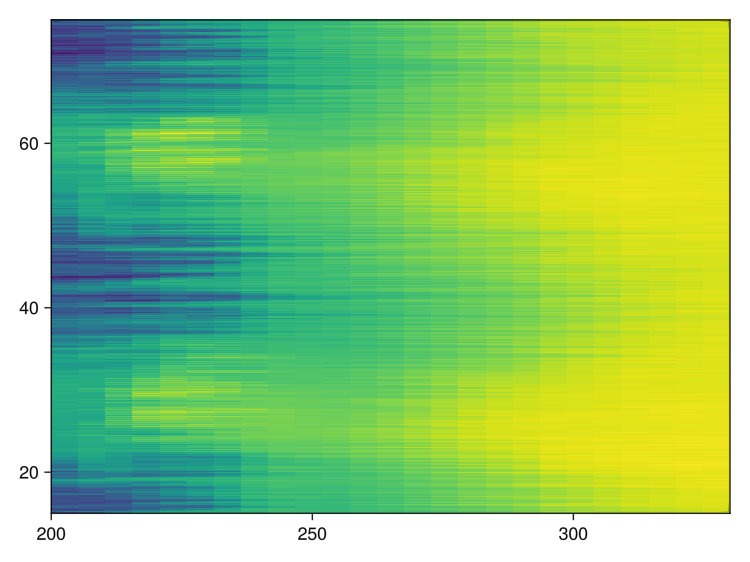

In [17]:
using GLMakie
heatmap(lon, lat, temp[1, :, :])

In [18]:
using Statistics
mean(temp, dims=3)# On what dimensions did we apply the reduction? I can't tell by looking at this line.

53×25×1 Array{Float64, 3}:
[:, :, 1] =
 260.376  262.734  264.769  267.683  …  297.326  297.65   298.129  298.366
 260.183  262.794  264.327  267.287     296.869  296.953  297.937  298.386
 259.887  262.749  264.062  267.136     296.537  296.629  297.47   298.114
 259.483  262.538  263.88   267.073     296.626  296.862  297.259  298.053
 259.017  262.159  263.695  266.948     296.387  296.893  297.455  297.943
 258.572  261.691  263.494  266.764  …  295.934  296.305  297.113  297.607
 258.245  261.246  263.324  266.644     295.617  296.062  296.9    297.539
 258.101  260.933  263.247  266.7       295.086  295.847  296.685  297.432
 258.155  260.795  263.263  266.897     294.632  295.358  296.232  297.394
 258.362  260.802  263.307  267.06      294.26   295.113  296.205  297.233
 258.625  260.867  263.295  267.037  …  293.616  294.714  296.16   297.108
 258.839  260.896  263.173  266.841     293.276  294.478  295.847  297.375
 258.919  260.829  262.956  266.617     292.893  294.489  295

### Analysis with DimensionalData

How readable is this code?


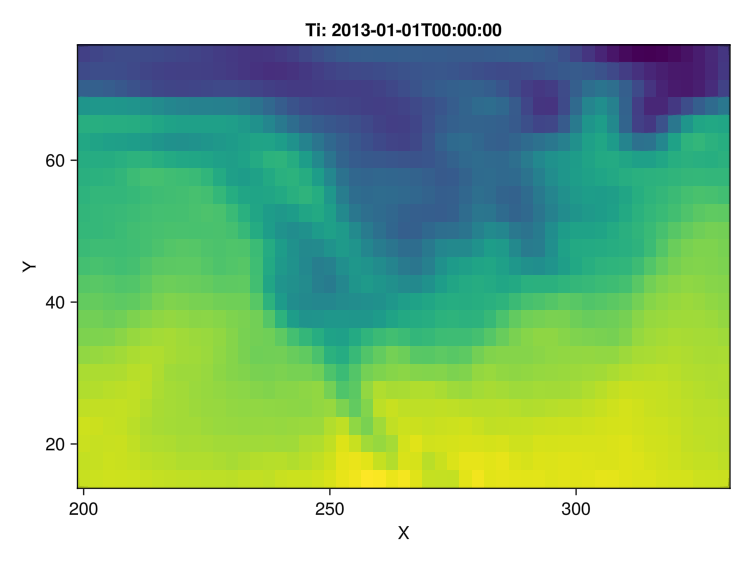

In [19]:
plot(ds.air[Ti=1])

Use dimension names instead of axis numbers


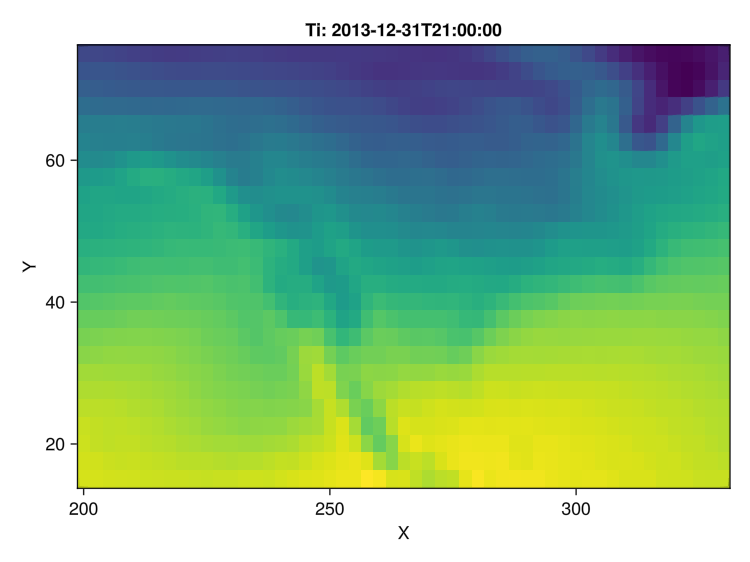

In [20]:
plot((mean(ds.air, dims=Ti)[Ti=1]))

---

## Extracting data or "indexing" 

DimensionalData supports

- label-based indexing using `Selector`s
- position-based indexing using `Integer`

See the [Documentation about Selectors](https://rafaqz.github.io/DimensionalData.jl/v0.27.0/selectors) for more.

### Label-based indexing

DimensionalData implements label based indexing where you can use the name of the dimension and also the labels for the entries in the dimension.


In [21]:
# here's what our dataset looks like
ds

╭────────────────────────╮
│ 53×25×2920 RasterStack │
├────────────────────────┴─────────────────────────────────────────────── dims ┐
  ↓ X  Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  ↗ Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :air eltype: Float64 dims: X, Y, Ti size: 53×25×2920
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 5 entries:
  "references"  => "http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly…
  "platform"    => "Model"
  "title"       => "4x daily NMC reanalysis (1948)"
  "description" => "Data is from NMC initialized reanalysis\n(4x/day).  These a…
  "Conventions" => "COARDS"
├────────────────────────────────────────

In [22]:
# We can extract the Time dimension
dims(ds, Ti)

Ti Sampled{DateTime} ForwardOrdered Irregular DimensionalData.Dimensions.Lookups.Points
wrapping: 2920-element Vector{DateTime}:
 2013-01-01T00:00:00
 2013-01-01T06:00:00
 2013-01-01T12:00:00
 2013-01-01T18:00:00
 2013-01-02T00:00:00
 2013-01-02T06:00:00
 2013-01-02T12:00:00
 2013-01-02T18:00:00
 2013-01-03T00:00:00
 2013-01-03T06:00:00
 2013-01-03T12:00:00
 2013-01-03T18:00:00
 2013-01-04T00:00:00
 ⋮
 2014-12-29T00:00:00
 2014-12-29T06:00:00
 2014-12-29T12:00:00
 2014-12-29T18:00:00
 2014-12-30T00:00:00
 2014-12-30T06:00:00
 2014-12-30T12:00:00
 2014-12-30T18:00:00
 2014-12-31T00:00:00
 2014-12-31T06:00:00
 2014-12-31T12:00:00
 2014-12-31T18:00:00

In [23]:
# pull out data for all of 2013-May
ds[Ti=Where(x->yearmonth(x) == (2013, 5))]

╭───────────────────────╮
│ 53×25×124 RasterStack │
├───────────────────────┴──────────────────────────────────────────────── dims ┐
  ↓ X  Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  ↗ Ti Sampled{DateTime} [2013-05-01T00:00:00, …, 2013-05-31T18:00:00] ForwardOrdered Irregular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :air eltype: Float64 dims: X, Y, Ti size: 53×25×124
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 5 entries:
  "references"  => "http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly…
  "platform"    => "Model"
  "title"       => "4x daily NMC reanalysis (1948)"
  "description" => "Data is from NMC initialized reanalysis\n(4x/day).  These a…
  "Conventions" => "COARDS"
├───────────────────────────────────────────

In [24]:
# demonstrate slicing, extract all time slices between to given dates
ds[Ti=Date(2013,5,1)..Date(2013,8,1)]

╭───────────────────────╮
│ 53×25×369 RasterStack │
├───────────────────────┴──────────────────────────────────────────────── dims ┐
  ↓ X  Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  ↗ Ti Sampled{DateTime} [2013-05-01T00:00:00, …, 2013-08-01T00:00:00] ForwardOrdered Irregular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :air eltype: Float64 dims: X, Y, Ti size: 53×25×369
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 5 entries:
  "references"  => "http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly…
  "platform"    => "Model"
  "title"       => "4x daily NMC reanalysis (1948)"
  "description" => "Data is from NMC initialized reanalysis\n(4x/day).  These a…
  "Conventions" => "COARDS"
├───────────────────────────────────────────

In [25]:
# demonstrate "nearest" indexing
ds[X=Near(240.2)]

╭─────────────────────╮
│ 25×2920 RasterStack │
├─────────────────────┴────────────────────────────────────────────────── dims ┐
  ↓ Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  → Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :air eltype: Float64 dims: Y, Ti size: 25×2920
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 5 entries:
  "references"  => "http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly…
  "platform"    => "Model"
  "title"       => "4x daily NMC reanalysis (1948)"
  "description" => "Data is from NMC initialized reanalysis\n(4x/day).  These a…
  "Conventions" => "COARDS"
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(Y = (15.0f0, 75.0f0), Ti = (DateTime("201

In [26]:
# "nearest indexing at multiple points"
ds[X=Near([240.125, 234]), Y=Near([40.1, 50.1])]

╭──────────────────────╮
│ 2×2×2920 RasterStack │
├──────────────────────┴───────────────────────────────────────────────── dims ┐
  ↓ X  Mapped{Float32} [240.0f0, 235.0f0] ForwardOrdered Irregular Points,
  → Y  Mapped{Float32} [40.0f0, 50.0f0] ReverseOrdered Irregular Points,
  ↗ Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :air eltype: Float64 dims: X, Y, Ti size: 2×2×2920
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 5 entries:
  "references"  => "http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly…
  "platform"    => "Model"
  "title"       => "4x daily NMC reanalysis (1948)"
  "description" => "Data is from NMC initialized reanalysis\n(4x/day).  These a…
  "Conventions" => "COARDS"
├──────────────────────────────────────────────────────────────────

These selectors can be mixed for different dimensions. So that we could have a `Where` selection for time and a nearest neighbor selection in space.

### Position-based indexing

This is similar to usual array indexing `array[1, 2, 3]` but with the power of named
dimensions!


In [27]:
# pull out time index 0, lat index 2, and lon index 3
ds.air[Ti=1, Y=2, X=3]  #  much better than ds.air[3, 2, 1]

244.70000000000002

In [28]:
# demonstrate slicing
ds.air[X=1:10]

╭──────────────────────────────────╮
│ 10×25×2920 Raster{Float64,3} air │
├──────────────────────────────────┴───────────────────────────────────── dims ┐
  ↓ X  Mapped{Float32} [200.0, 202.5, …, 220.0, 222.5] ForwardOrdered Regular Points,
  → Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  ↗ Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 13 entries:
  "long_name"    => "4xDaily Air temperature at sigma level 995"
  "scale_factor" => 0.01
  "GRIB_name"    => "TMP"
  "precision"    => 2
  "var_desc"     => "Air temperature"
  "actual_range" => Float32[185.16, 322.1]
  "statistic"    => "Individual Obs"
  "GRIB_id"      => 11
  "myattrs"      => "Mine"
  "dataset"      => "NMC Reanalysis"
  "units"        => "degK"
  "parent_stat"  => "Other"
  "level_desc"   => "Surfac

---

## Concepts for computation

Consider calculating the *mean air temperature per unit surface area* for this dataset. Because latitude and longitude correspond to spherical coordinates for Earth's surface, each 2.5x2.5 degree grid cell actually has a different surface area as you move away from the equator! This is because *latitudinal length* is fixed ($ \delta Lat = R \delta \phi  $), but *longitudinal length varies with latitude* ($ \delta Lon = R \delta \lambda \cos(\phi) $)

So the [area element for lat-lon coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Integration_and_differentiation_in_spherical_coordinates) is


$$ \delta A = R^2 \delta\phi \, \delta\lambda \cos(\phi) $$

where $\phi$ is latitude, $\delta \phi$ is the spacing of the points in latitude, $\delta \lambda$ is the spacing of the points in longitude, and $R$ is Earth's radius. (In this formula, $\phi$ and $\lambda$ are measured in radians)

In [30]:
lon

53-element Vector{Float32}:
 200.0
 202.5
 205.0
 207.5
 210.0
 212.5
 215.0
 217.5
 220.0
 222.5
 225.0
 227.5
 230.0
   ⋮
 302.5
 305.0
 307.5
 310.0
 312.5
 315.0
 317.5
 320.0
 322.5
 325.0
 327.5
 330.0

In [91]:
# Earth's average radius in meters
R = 6.371e6

# Coordinate spacing for this dataset is 2.5 x 2.5 degrees
dϕ = deg2rad(2.5)
dλ = deg2rad(2.5)

dlat = fill(R * dϕ, dims(ds,X))

╭──────────────────────────────╮
│ 53-element Raster{Float64,1} │
├──────────────────────────────┴───────────────────────────────────────── dims ┐
  ↓ X Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (200.0f0, 330.0f0),)

  crs: EPSG:4326
  mappedcrs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
 200.0  2.77987e5
 202.5  2.77987e5
 205.0  2.77987e5
 207.5  2.77987e5
 210.0  2.77987e5
 212.5  2.77987e5
 215.0  2.77987e5
 217.5  2.77987e5
 220.0  2.77987e5
   ⋮    
 312.5  2.77987e5
 315.0  2.77987e5
 317.5  2.77987e5
 320.0  2.77987e5
 322.5  2.77987e5
 325.0  2.77987e5
 327.5  2.77987e5
 330.0  2.77987e5

In [92]:
dlonval = R .* dλ .* cos.(deg2rad.(dims(ds.air, Y)))
dlon = DimArray(reshape(dlonval, (1, length(dlonval))), (X,dims(ds, Y)))

╭──────────────────────────╮
│ 1×25 DimArray{Float64,2} │
├──────────────────────────┴───────────────────────────────────────────── dims ┐
  ↓ X,
  → Y Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points
└──────────────────────────────────────────────────────────────────────────────┘
    75.0     72.5     70.0  67.5        …  20.0        17.5        15.0
 71948.4  83592.4  95077.3   1.06381e5      2.61223e5   2.65121e5   2.68515e5

In [94]:
cell_area = dlat .* dlon

╭─────────────────────────╮
│ 53×25 Raster{Float64,2} │
├─────────────────────────┴────────────────────────────────────────────── dims ┐
  ↓ X Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (200.0f0, 330.0f0), Y = (15.0f0, 75.0f0))

  crs: EPSG:4326
  mappedcrs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
   ↓ →  75.0         72.5         70.0         …  17.5         15.0
 200.0   2.00007e10   2.32376e10   2.64303e10      7.37003e10   7.46438e10
 202.5   2.00007e10   2.32376e10   2.64303e10      7.37003e10   7.46438e10
 205.0   2.00007e10   2.32376e10   2.64303e10      7.37003e10   7.46438e10
 207.5   2.00007e10   2.32376e10   2.64303e10      7.37003e10   7.46438e10
 210.0   2.00007e10   2.32376e10   2.64303e10  …   7.37003e10   

You can apply functions like `cos` and `deg2rad` elementwise on array types by using broadcasting in Julia.

### Broadcasting: expanding data

In DimensionalData the broadcast does not automatically expand the data therefore we have to reshape the underlying data into a row vector to get a 2D array from the two 1D vectors.

In [95]:
cell_area = dlon .* dlat
cell_area

╭───────────────────────────╮
│ 53×25 DimArray{Float64,2} │
├───────────────────────────┴──────────────────────────────────────────── dims ┐
  ↓ X Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points
└──────────────────────────────────────────────────────────────────────────────┘
   ↓ →  75.0         72.5         70.0         …  17.5         15.0
 200.0   2.00007e10   2.32376e10   2.64303e10      7.37003e10   7.46438e10
 202.5   2.00007e10   2.32376e10   2.64303e10      7.37003e10   7.46438e10
 205.0   2.00007e10   2.32376e10   2.64303e10      7.37003e10   7.46438e10
 207.5   2.00007e10   2.32376e10   2.64303e10      7.37003e10   7.46438e10
 210.0   2.00007e10   2.32376e10   2.64303e10  …   7.37003e10   7.46438e10
 212.5   2.00007e10   2.32376e10   2.64303e10      7.37003e10   7.46438e10
 215.0   2.00007e10   2.32376e10   2.64303e10      7.37003e10   7.46438e10
   ⋮                

---

### Alignment: putting data on the same grid

When broadcasting arithmetic operations DimensionalData automatically "aligns" i.e. puts the
data on the same grid. In this case `cell_area` and `ds.air` are at the same
lat, lon points we end up with a result with the same shape (25x53):


In [73]:
ds.air[Ti=1] ./ cell_area

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 53 and 25

DimensionalData only compares the dimension name and would currently broadcast two arrays with the same size along each dimension together.

In [109]:
# make a copy of cell_area
# then add 1e-5 degrees to latitude
cell_area_bad = similar(cell_area)

╭─────────────────────────╮
│ 53×25 Raster{Float64,2} │
├─────────────────────────┴────────────────────────────────────────────── dims ┐
  ↓ X Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (200.0f0, 330.0f0), Y = (15.0f0, 75.0f0))

  crs: EPSG:4326
  mappedcrs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
   ↓ →  75.0            72.5           …   17.5            15.0
 200.0   9.61286e-316    0.0                3.13151e-294    0.0
 202.5   9.61286e-316  NaN                  1.02641e-315    0.0
 205.0   8.93371e-253    1.0e-323           0.0             0.0
 207.5   0.0             0.0                0.0             0.0
 210.0   9.47351e-316    9.51922e-316  …    9.61341e-316    2.41348e-316
 212.5   1.0e-323        2.2767e-320   

In [121]:
set(cell_area_bad, set(dims(cell_area_bad, X), 1:53))

╭─────────────────────────╮
│ 53×25 Raster{Float64,2} │
├─────────────────────────┴────────────────────────────────────────────── dims ┐
  ↓ X Mapped{Int64} 1:53 ForwardOrdered Regular Points,
  → Y Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (1, 53), Y = (15.0f0, 75.0f0))

  crs: EPSG:4326
  mappedcrs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
  ↓ →  75.0            72.5           …   17.5            15.0
  1     9.61286e-316    0.0                3.13151e-294    0.0
  2     9.61286e-316  NaN                  1.02641e-315    0.0
  3     8.93371e-253    1.0e-323           0.0             0.0
  4     0.0             0.0                0.0             0.0
  5     9.47351e-316    9.51922e-316  …    9.61341e-316    2.41348e-316
  6     1.0e-323        2.2767e-320        1.01969e-315    0.0
  7     0.0           

In [120]:
cell_area_bad .* ds.air[Ti=1]

╭─────────────────────────╮
│ 53×25 Raster{Float64,2} │
├─────────────────────────┴────────────────────────────────────────────── dims ┐
  ↓ X Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(X = (200.0f0, 330.0f0), Y = (15.0f0, 75.0f0))

  crs: EPSG:4326
  mappedcrs: EPSG:4326
└──────────────────────────────────────────────────────────────────────────────┘
   ↓ →  75.0            72.5           …   17.5            15.0
 200.0   2.31862e-313    0.0                9.26615e-292    0.0
 202.5   2.33112e-313  NaN                  3.04021e-313    0.0
 205.0   2.17536e-250    2.416e-321         0.0             0.0
 207.5   0.0             0.0                0.0             0.0
 210.0   2.31248e-313    2.31688e-313  …    2.84653e-313    7.16563e-314
 212.5   2.41e-321       5.51838e-318  

This results in the same values but the dimensions are different. 

---

## High level computation 

(`groupby`, `resample`, `rolling`, `coarsen`, `weighted`)

Xarray has some very useful high level objects that let you do common
computations:

1. `groupby` :
   [Bin data in to groups and reduce](https://docs.xarray.dev/en/stable/groupby.html)
1. `resample` :
   [Groupby specialized for time axes. Either downsample or upsample your data.](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
1. `rolling` :
   [Operate on rolling windows of your data e.g. running mean](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations)
1. `coarsen` :
   [Downsample your data](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays)
1. `weighted` :
   [Weight your data before reducing](https://docs.xarray.dev/en/stable/user-guide/computation.html#weighted-array-reductions)


Below we quickly demonstrate these patterns. See the user guide links above and [the tutorial](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html) for more.

### groupby


In [122]:
# here's ds
ds

╭────────────────────────╮
│ 53×25×2920 RasterStack │
├────────────────────────┴─────────────────────────────────────────────── dims ┐
  ↓ X  Mapped{Float32} [200.0, 202.5, …, 327.5, 330.0] ForwardOrdered Regular Points,
  → Y  Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points,
  ↗ Ti Sampled{DateTime} [2013-01-01T00:00:00, …, 2014-12-31T18:00:00] ForwardOrdered Irregular Points
├────────────────────────────────────────────────────────────────────── layers ┤
  :air eltype: Float64 dims: X, Y, Ti size: 53×25×2920
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 5 entries:
  "references"  => "http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly…
  "platform"    => "Model"
  "title"       => "4x daily NMC reanalysis (1948)"
  "description" => "Data is from NMC initialized reanalysis\n(4x/day).  These a…
  "Conventions" => "COARDS"
├────────────────────────────────────────

In [143]:
groups = groupby(ds, Ti=>seasons())

╭──────────────────────────────────────────────────────────────────────────────╮
│ 4-element DimGroupByArray{RasterStack{(:air,), @NamedTuple{air::Float64}, 2, @NamedTuple{air::SubArray{Float64, 2, Array{Float64, 3}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Tuple{X{Mapped{Float32, Vector{Float32}, DimensionalData.Dimensions.Lookups.ForwardOrdered, DimensionalData.Dimensions.Lookups.Regular{Float32}, DimensionalData.Dimensions.Lookups.Points, DimensionalData.Dimensions.Lookups.Metadata{Rasters.NCDsource, Dict{String, Any}}, EPSG{1}, EPSG{1}, X{Colon}}}, Y{Mapped{Float32, Vector{Float32}, DimensionalData.Dimensions.Lookups.ReverseOrdered, DimensionalData.Dimensions.Lookups.Regular{Float32}, DimensionalData.Dimensions.Lookups.Points, DimensionalData.Dimensions.Lookups.Metadata{Rasters.NCDsource, Dict{String, Any}}, EPSG{1}, EPSG{1}, Y{Colon}}}}, Tuple{Ti{DimensionalData.Dimensions.Lookups.Sampled{DateTime, SubArray{DateTime, 1, Vector{DateTime}, 

In [145]:
# make a seasonal mean
seasonal_mean = mean.(groups, dims=Ti)
seasonal_mean

╭──────────────────────────────────────────────────────────────────────────────╮
│ 4-element DimGroupByArray{RasterStack{(:air,), @NamedTuple{air::Float64}, 3, @NamedTuple{air::Array{Float64, 3}}, Tuple{X{Mapped{Float32, Vector{Float32}, DimensionalData.Dimensions.Lookups.ForwardOrdered, DimensionalData.Dimensions.Lookups.Regular{Float32}, DimensionalData.Dimensions.Lookups.Points, DimensionalData.Dimensions.Lookups.Metadata{Rasters.NCDsource, Dict{String, Any}}, EPSG{1}, EPSG{1}, X{Colon}}}, Y{Mapped{Float32, Vector{Float32}, DimensionalData.Dimensions.Lookups.ReverseOrdered, DimensionalData.Dimensions.Lookups.Regular{Float32}, DimensionalData.Dimensions.Lookups.Points, DimensionalData.Dimensions.Lookups.Metadata{Rasters.NCDsource, Dict{String, Any}}, EPSG{1}, EPSG{1}, Y{Colon}}}, Ti{DimensionalData.Dimensions.Lookups.Sampled{DateTime, Vector{DateTime}, DimensionalData.Dimensions.Lookups.ForwardOrdered, DimensionalData.Dimensions.Lookups.Irregular{Tuple{DateTime, DateTime}}, Dimension

In [154]:
#TODO: Plot the mean map for every season

### resample


In [61]:
# Reduce the time dimension to monthly means 
monthlymeans = dropdims.(mean.(groupby(ds.air, Ti=>yearmonth), dims=Ti), dims=Ti)

╭─────────────────────────────────────────────────╮
│ 24-element DimGroupByArray{Raster{Float64,2},1} │
├─────────────────────────────────────────────────┴────────────────────── dims ┐
  ↓ Ti Sampled{Tuple{Int64, Int64}} [(2013, 1), (2013, 2), …, (2014, 11), (2014, 12)] ForwardOrdered Irregular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Dict{Symbol, Any} with 1 entry:
  :groupby => :Ti=>yearmonth
├────────────────────────────────────────────────────────────────── group dims ┤
  ↓ X, → Y
└──────────────────────────────────────────────────────────────────────────────┘
 (2013, 1)   53×25 Raster
 (2013, 2)   53×25 Raster
 (2013, 3)   53×25 Raster
 (2013, 4)   53×25 Raster
 (2013, 5)   53×25 Raster
 (2013, 6)   53×25 Raster
 ⋮           
 (2014, 8)   53×25 Raster
 (2014, 9)   53×25 Raster
 (2014, 10)  53×25 Raster
 (2014, 11)  53×25 Raster
 (2014, 12)  53×25 Raster

### weighted


In [115]:
# weight by cell_area and take mean over (time, lon)
#ds.weighted(cell_area).mean(["lon", "time"]).air.plot(y="lat");
weightedmean = dropdims(mean(ds.air, dims=(X, Ti)), dims=(X,Ti))
weightedmean

╭──────────────────────────────────╮
│ 25-element Raster{Float64,1} air │
├──────────────────────────────────┴───────────────────────────────────── dims ┐
  ↓ Y Mapped{Float32} [75.0, 72.5, …, 17.5, 15.0] ReverseOrdered Regular Points
├──────────────────────────────────────────────────────────────────── metadata ┤
  Metadata{Rasters.NCDsource} of Dict{String, Any} with 13 entries:
  "long_name"    => "4xDaily Air temperature at sigma level 995"
  "scale_factor" => 0.01
  "GRIB_name"    => "TMP"
  "precision"    => 2
  "var_desc"     => "Air temperature"
  "actual_range" => Float32[185.16, 322.1]
  "statistic"    => "Individual Obs"
  "GRIB_id"      => 11
  "myattrs"      => "Mine"
  "dataset"      => "NMC Reanalysis"
  "units"        => "degK"
  "parent_stat"  => "Other"
  "level_desc"   => "Surface"
├────────────────────────────────────────────────────────────────────── raster ┤
  extent: Extent(Y = (15.0f0, 75.0f0),)

  crs: EPSG:4326
  mappedcrs: EPSG:4326
└─────────────────────────

In [118]:
y = dims(weightedmean, Y)
@show y

y = Y{Mapped{Float32, Vector{Float32}, DimensionalData.Dimensions.Lookups.ReverseOrdered, DimensionalData.Dimensions.Lookups.Regular{Float32}, DimensionalData.Dimensions.Lookups.Points, DimensionalData.Dimensions.Lookups.Metadata{Rasters.NCDsource, Dict{String, Any}}, EPSG{1}, EPSG{1}, Y{Colon}}}(Float32[75.0, 72.5, 70.0, 67.5, 65.0, 62.5, 60.0, 57.5, 55.0, 52.5, 50.0, 47.5, 45.0, 42.5, 40.0, 37.5, 35.0, 32.5, 30.0, 27.5, 25.0, 22.5, 20.0, 17.5, 15.0])


Y Mapped{Float32} ReverseOrdered Regular DimensionalData.Dimensions.Lookups.Points
wrapping: 25-element Vector{Float32}:
 75.0
 72.5
 70.0
 67.5
 65.0
 62.5
 60.0
 57.5
 55.0
 52.5
 50.0
 47.5
 45.0
 42.5
 40.0
 37.5
 35.0
 32.5
 30.0
 27.5
 25.0
 22.5
 20.0
 17.5
 15.0

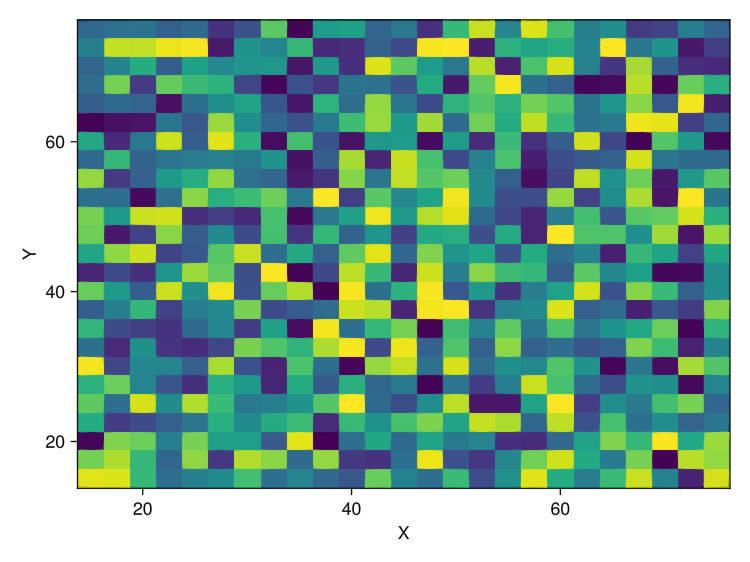

In [133]:
nx = X(reverse(Float32[75.0, 72.5, 70.0, 67.5, 65.0, 62.5, 60.0, 57.5, 55.0, 52.5, 50.0, 47.5, 45.0, 42.5, 40.0, 37.5, 35.0, 32.5, 30.0, 27.5, 25.0, 22.5, 20.0, 17.5, 15.0]))
ny = Y(reverse(Float32[75.0, 72.5, 70.0, 67.5, 65.0, 62.5, 60.0, 57.5, 55.0, 52.5, 50.0, 47.5, 45.0, 42.5, 40.0, 37.5, 35.0, 32.5, 30.0, 27.5, 25.0, 22.5, 20.0, 17.5, 15.0]))

narr = DimArray(rand(25,25), (ny, nx))
fig, ax, pl = plot(narr)

In [135]:
nsingle = DimArray(rand(25), ny)

╭────────────────────────────────╮
│ 25-element DimArray{Float64,1} │
├────────────────────────────────┴─────────────────────────────────────── dims ┐
  ↓ Y Sampled{Float32} [15.0, 17.5, …, 72.5, 75.0] ForwardOrdered Irregular Points
└──────────────────────────────────────────────────────────────────────────────┘
 15.0  0.0524976
 17.5  0.448537
 20.0  0.140383
 22.5  0.255699
 25.0  0.943593
 27.5  0.207551
 30.0  0.805292
 32.5  0.268144
 35.0  0.0403911
  ⋮    
 57.5  0.565343
 60.0  0.338049
 62.5  0.330381
 65.0  0.0571293
 67.5  0.375037
 70.0  0.974702
 72.5  0.0011732
 75.0  0.620473

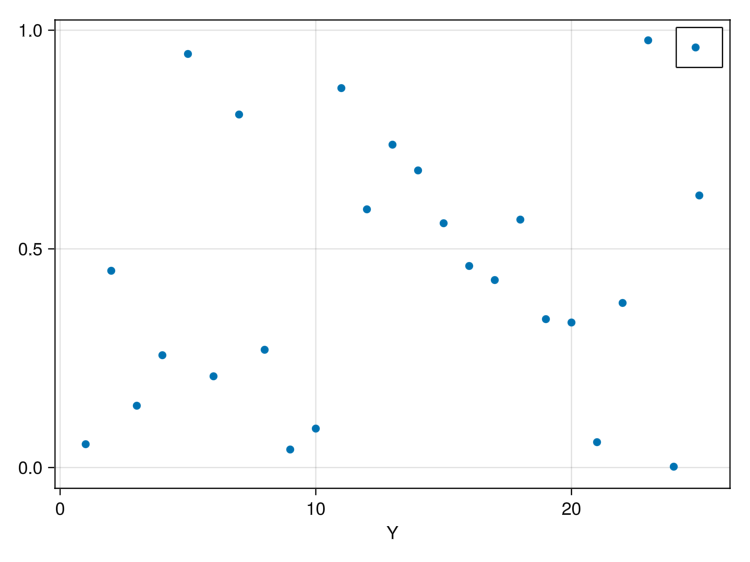

In [136]:
fig, ax, pl = plot(nsingle)

In [138]:
ax.finallimits

Observable(GeometryBasics.HyperRectangle{2, Float32}(Float32[-0.20000002, -0.047503244], Float32[26.4, 1.0708817]))
    0 => map((::Makie.var"#1456#1457")(bbox, limits, aspect) @ Makie ~/.julia/packages/Makie/ND0gA/src/makielayout/helpers.jl:16)
    0 => map(Makie.xlimits)
    0 => map(Makie.ylimits)
    0 => map(_selection_vertices(ax_scene, outer, inner) @ Makie ~/.julia/packages/Makie/ND0gA/src/makielayout/interactions.jl:124)
    -2 => onany(update_axis_camera(camera::Camera, t, lims, xrev::Bool, yrev::Bool) @ Makie ~/.julia/packages/Makie/ND0gA/src/makielayout/blocks/axis.jl:75)


---

## Visualization

(`.plot`)


We have seen very simple plots earlier. Xarray also lets you easily visualize
3D and 4D datasets by presenting multiple facets (or panels or subplots) showing
variations across rows and/or columns.

In [ ]:
# facet the seasonal_mean
seasonal_mean.air.plot(col="season", col_wrap=2);

In [ ]:
# contours
seasonal_mean.air.plot.contour(col="season", levels=20, add_colorbar=True);

In [ ]:
# line plots too? wut
seasonal_mean.air.mean("lon").plot.line(hue="season", y="lat");

For more see the [user guide](https://docs.xarray.dev/en/stable/plotting.html), the [gallery](https://docs.xarray.dev/en/stable/examples/visualization_gallery.html), and [the tutorial material](https://tutorial.xarray.dev/fundamentals/04.0_plotting.html).

---

## Reading and writing files

Xarray supports many disk formats. Below is a small example using netCDF. For
more see the [documentation](https://docs.xarray.dev/en/stable/user-guide/io.html)


In [ ]:
# write to netCDF
ds.to_netcdf("my-example-dataset.nc")

```{note}
To avoid the `SerializationWarning` you can assign a _FillValue for any NaNs in 'air' array by adding the keyword argument encoding=dict(air={_FillValue=-9999})
```

In [ ]:
# read from disk
fromdisk = xr.open_dataset("my-example-dataset.nc")
fromdisk

In [ ]:
# check that the two are identical
ds.identical(fromdisk)

```{tip}
A common use case to read datasets that are a collection of many netCDF
files. See the [documentation](https://docs.xarray.dev/en/stable/user-guide/io.html#reading-multi-file-datasets) for how
to handle that.
```

Finally to read other file formats, you might find yourself reading in the data using a different library and then creating a DataArray([docs](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#creating-a-dataarray), [tutorial](https://tutorial.xarray.dev/fundamentals/01.1_creating_data_structures.html)) from scratch. For example, you might use `h5py` to open an HDF5 file and then create a Dataset from that.
For MATLAB files you might use `scipy.io.loadmat` or `h5py` depending on the version of MATLAB file you're opening and then construct a Dataset.

---

## The scientific python ecosystem

Xarray ties in to the larger scientific python ecosystem and in turn many
packages build on top of xarray. A long list of such packages is here:
<https://docs.xarray.dev/en/stable/related-projects.html>.

Now we will demonstrate some cool features.


### Pandas: tabular data structures

You can easily [convert](https://docs.xarray.dev/en/stable/pandas.html) between xarray and [pandas](https://pandas.pydata.org/) structures. This allows you to conveniently use the extensive pandas 
ecosystem of packages (like [seaborn](https://seaborn.pydata.org/)) for your work.


In [ ]:
# convert to pandas dataframe
df = ds.isel(time=slice(10)).to_dataframe()
df

In [ ]:
# convert dataframe to xarray
df.to_xarray()

### Alternative array types

This notebook has focused on Numpy arrays. Xarray can wrap [other array](https://docs.xarray.dev/en/stable/user-guide/duckarrays.html) types! For example:

<img src="https://docs.dask.org/en/stable/_images/dask_horizontal.svg" width="20%"> [distributed parallel arrays](https://docs.dask.org/en/latest/array.html) & [Xarray user guide on Dask](https://docs.xarray.dev/en/stable/user-guide/dask.html)

<img src="https://raw.githubusercontent.com/pydata/sparse/master/docs/logo.svg" width="15%"> **pydata/sparse** : [sparse arrays](https://sparse.pydata.org)

<img src="https://raw.githubusercontent.com/cupy/cupy.dev/master/images/cupy_logo.png" width="22%"> [GPU arrays](https://cupy.dev) & [cupy-xarray](https://cupy-xarray.readthedocs.io/)

<img src="https://pint.readthedocs.io/en/stable/_static/logo-full.jpg" width="10%"> **pint** : [unit-aware arrays](https://pint.readthedocs.io) & [pint-xarray](https://github.com/xarray-contrib/pint-xarray)


### Dask

Dask cuts up NumPy arrays into blocks and parallelizes your analysis code across
these blocks

<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/dask-array.svg" style="width:45%">


In [ ]:
# demonstrate dask dataset
dasky = xr.tutorial.open_dataset(
    "air_temperature",
    chunks={"time": 10},  # 10 time steps in each block
)

dasky.air

All computations with dask-backed xarray objects are lazy, allowing you to build
up a complicated chain of analysis steps quickly


In [ ]:
# demonstrate lazy mean
dasky.air.mean("lat")

To get concrete values, call `.compute` or `.load`


In [ ]:
# "compute" the mean
dasky.air.mean("lat").compute()

### HoloViz

Quickly generate interactive plots from your data!

The [`hvplot` package](https://hvplot.holoviz.org/user_guide/Gridded_Data.html) attaches itself to all
xarray objects under the `.hvplot` namespace. So instead of using `.plot` use `.hvplot`

In [ ]:
import hvplot.xarray

ds.air.hvplot(groupby="time", clim=(270, 300), widget_location='bottom')

```{note}
The time slider will only work if you're executing the notebook, rather than viewing the website
```

### cf_xarray 

[cf_xarray](https://cf-xarray.readthedocs.io/) is a project that tries to
let you make use of other CF attributes that xarray ignores. It attaches itself
to all xarray objects under the `.cf` namespace.

Where xarray allows you to specify dimension names for analysis, `cf_xarray`
lets you specify logical names like `"latitude"` or `"longitude"` instead as
long as the appropriate CF attributes are set.

For example, the `"longitude"` dimension in different files might be labelled as: (lon, LON, long, x…), but cf_xarray let's you always refer to the logical name `"longitude"` in your code:

In [ ]:
import cf_xarray

In [ ]:
# describe cf attributes in dataset
ds.air.cf

The following `mean` operation will work with any dataset that has appropriate
attributes set that allow detection of the "latitude" variable (e.g.
`units: "degress_north"` or `standard_name: "latitude"`)


In [ ]:
# demonstrate equivalent of .mean("lat")
ds.air.cf.mean("latitude")

In [ ]:
# demonstrate indexing
ds.air.cf.sel(longitude=242.5, method="nearest")

### Other cool packages

- [xgcm](https://xgcm.readthedocs.io/) : grid-aware operations with xarray
  objects
- [xrft](https://xrft.readthedocs.io/) : fourier transforms with xarray
- [xclim](https://xclim.readthedocs.io/) : calculating climate indices with
  xarray objects
- [intake-xarray](https://intake-xarray.readthedocs.io/) : forget about file
  paths
- [rioxarray](https://corteva.github.io/rioxarray/stable/index.html) : raster
  files and xarray
- [xesmf](https://xesmf.readthedocs.io/) : regrid using ESMF
- [MetPy](https://unidata.github.io/MetPy/latest/index.html) : tools for working
  with weather data

Check the Xarray [Ecosystem](https://docs.xarray.dev/en/stable/ecosystem.html) page and [this tutorial](https://tutorial.xarray.dev/intermediate/xarray_ecosystem.html) for even more packages and demonstrations.

## Next

1. Read the [tutorial](https://tutorial.xarray.dev) material and [user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)
1. See the description of [common terms](https://docs.xarray.dev/en/stable/terminology.html) used in the xarray documentation: 
1. Answers to common questions on "how to do X" with Xarray are [here](https://docs.xarray.dev/en/stable/howdoi.html)
1. Ryan Abernathey has a book on data analysis with a [chapter on Xarray](https://earth-env-data-science.github.io/lectures/xarray/xarray_intro.html)
1. [Project Pythia](https://projectpythia.org/) has [foundational](https://foundations.projectpythia.org/landing-page.html) and more [advanced](https://cookbooks.projectpythia.org/) material on Xarray. Pythia also aggregates other [Python learning resources](https://projectpythia.org/resource-gallery.html).
1. The [Xarray Github Discussions](https://github.com/pydata/xarray/discussions) and [Pangeo Discourse](https://discourse.pangeo.io/) are good places to ask questions.
1. Tell your friends! Tweet!


## Welcome!

DimensionalData and the whole Julia data analyiss ecosystem is an open-source project and gladly welcomes all kinds of contributions. This could include reporting bugs, discussing new enhancements, contributing code, helping answer user questions, contributing documentation (even small edits like fixing spelling mistakes or rewording to make the text clearer). Welcome!